In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

In [32]:
# ... load real data

data = {
    'G': _pnd.read_table('/home/dimitris/Data/Geuvadis/VCF/genotypes.TF.common.HIGH.txt', index_col=0, header=None),
    'Z': _pnd.read_table('/home/dimitris/Data/Geuvadis/counts/counts_miRNAs.txt', index_col=0)
}

samples = data['G'].index & data['Z'].columns

data['Z'] = data['Z'][samples].values
data['G'] = data['G'].loc[samples].values

(452, 21) (223, 452)


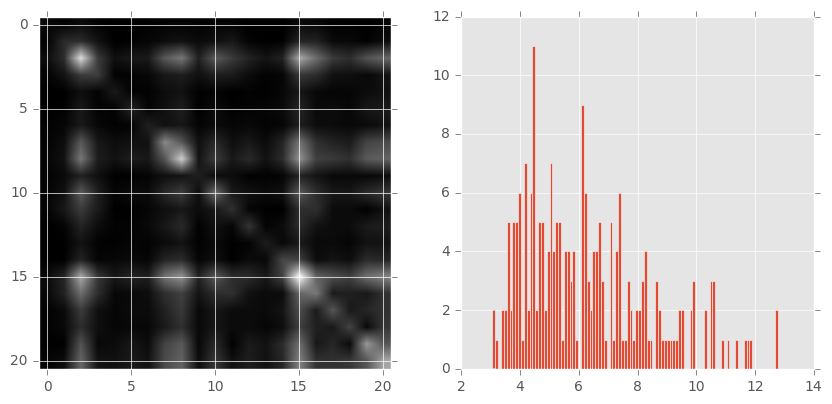

In [92]:
# prepare data

Z = data['Z']
G = data['G']

Z = Z[Z.sum(1) > 0, :]       # keep only expressed tags
Z = Z[Z.sum(1) > _nmp.percentile(Z.sum(1), 90), :]
G = G[:, _nmp.std(G, 0) > 0] # keep only non-monomorphic loci

Z = Z / _assoc.calculate_norm_factors(Z)
Z = _assoc.transform_data(Z, kind='log')

print(G.shape, Z.shape)

# take a quick look at the data

_plt.figure(figsize=(10,10));
_plt.subplot(2,2,1); _plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);
_plt.subplot(2,2,2); _plt.hist(Z[:, 0], bins=100);

In [93]:
_rnd.seed(0)
res = _assoc.run(Z.T, G, n_iters = 1000, model='Normal', n_threads=4)

/home/dimitris/VENVS/py35mkl/lib/python3.5/site-packages/tqdm/_tqdm.py:65: DeprecationWarning: sys.getcheckinterval() and sys.setcheckinterval() are deprecated.  Use sys.setswitchinterval() instead.
  sys.setcheckinterval(100)
100%|██████████| 1000/1000 [00:05<00:00, 207.41it/s]


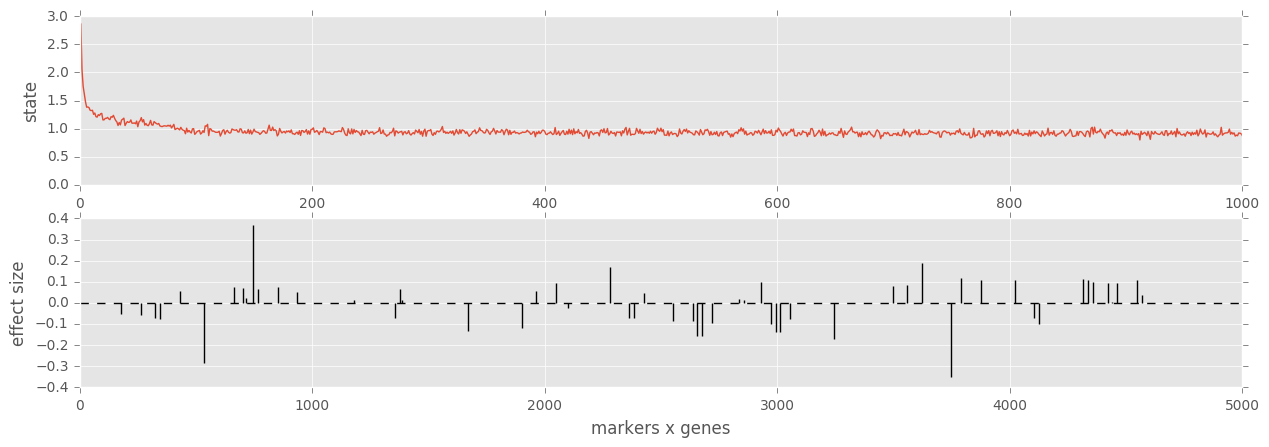

In [94]:
_plt.figure(figsize = (15,10));

_plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

_plt.subplot(4,1,2); _plt.vlines(range(res['beta'].size), 0, res['beta'].ravel()); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
_plt.axhline(linestyle='--', color='k');

In [95]:
_nmp.transpose((_nmp.abs(res['beta']) > 1e-6).nonzero()).shape

(56, 2)

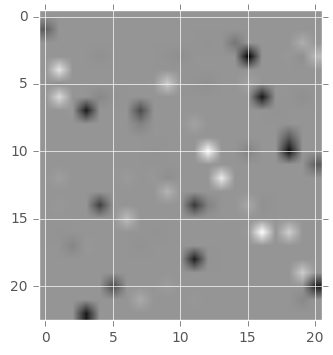

In [77]:
_plt.imshow(res['beta'][::100, :], cmap=_plt.cm.gray)

In [74]:
res_nbin = res

In [8]:
import pickle as _pkl

In [78]:
files = {
    'Normal.log': res_log ,
    'Normal.boxcox': res_bcox,
    'Normal.blom': res_blom,
    'Normal.voom': res_voom,
    'Normal.vst': res_vst,
    'Binomial.none': res_bin,
    'NBinomial.none': res_nbin,
    'Poisson.none': res_pois
}

for key in files:
    f = 'TF.common.HIGH.miRNAs.452.{}'.format(key)
    out = files[key]
    with open('/home/dimitris/WTCHG/Projects/eQTLseq/results/geuvadis/ROC/{}.pkl'.format(f), 'wb') as fh:
        _pkl.dump(out, fh)

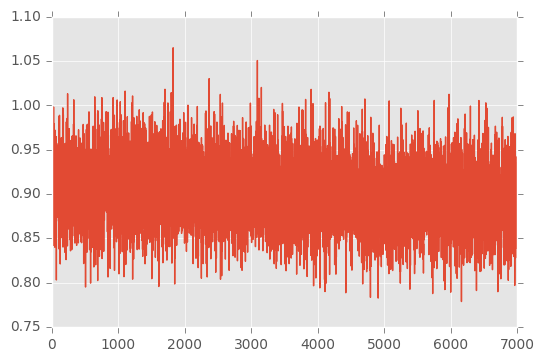

In [88]:
_plt.plot(res['state'][1000:])

In [30]:
with open('results/geuvadis/TF.common.HIGH.miRNAs.452.Normal.voom.pkl', 'rb') as fh:
    res = _pkl.load(fh)

In [96]:
_assoc.get_metrics(Z.T, G, res, model='Normal', scaleG=True, centreZ=True)

{'PCC': 0.11444265574995643,
 'R2': 1.0,
 'RHO': 0.065606738660853925,
 'X2': 34664813.822467275,
 'X2c': -0.56198475304052964,
 'X2p': 1.0099877268677104,
 'nMSE': 1.8918100584501716}

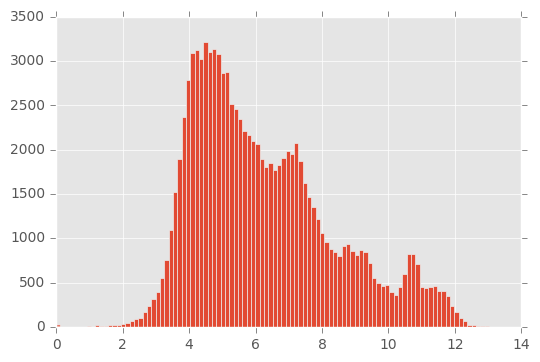

In [97]:
_plt.hist(Z.ravel(), 100);

In [98]:
res

{'beta': array([[ -1.11573319e-19,  -4.00153129e-20,   3.17014807e-15, ...,
          -1.06286140e-14,  -1.58182620e-15,   4.13669742e-15],
        [ -7.55404042e-20,  -4.27569062e-20,   4.54858945e-15, ...,
          -8.66079763e-15,   1.47626580e-15,   4.71309878e-15],
        [  5.95094794e-08,  -3.71482446e-11,   1.69838238e-08, ...,
           2.21857014e-09,  -2.37653594e-11,   1.34176514e-07],
        ..., 
        [  2.88375880e-12,   1.92807891e-11,   4.05034681e-11, ...,
           1.32942740e-12,   4.74533868e-08,  -6.61974945e-13],
        [  1.48782633e-13,   3.98070932e-13,   3.18106418e-13, ...,
          -1.97355073e-13,   6.92227532e-13,   5.48069196e-14],
        [  1.96058843e-13,   7.40511930e-12,   2.56678924e-12, ...,
          -7.08656061e-13,  -3.37928786e-12,  -7.44094052e-12]]),
 'beta_var': array([[  9.14582504e-37,   2.16292098e-36,   3.47530295e-27, ...,
          -2.62323073e-42,   2.06691523e-44,  -1.23314265e-43],
        [  3.67324044e-36,   2.09044468e